In [1]:
import os, shutil, pathlib
import kagglehub

# 1) Download (cached under ~/.cache/kagglehub)
src_path = kagglehub.dataset_download("shubhamdamai/ab-testing-analysis-facebook-vs-adword")
print("Downloaded to:", src_path)

# 2) Ensure target dir exists
target_dir = pathlib.Path("/home/enma/Projects/Data_Analysis_Playbook/data")
target_dir.mkdir(parents=True, exist_ok=True)

# 3) Copy all files from the downloaded folder to target (overwrite if exists)
for p in pathlib.Path(src_path).glob("*"):
    dest = target_dir / p.name
    if p.is_dir():
        if dest.exists():
            shutil.rmtree(dest)
        shutil.copytree(p, dest)
    else:
        shutil.copy2(p, dest)

print("Placed files in:", target_dir)


Downloaded to: /home/enma/.cache/kagglehub/datasets/shubhamdamai/ab-testing-analysis-facebook-vs-adword/versions/1
Placed files in: /home/enma/Projects/Data_Analysis_Playbook/data


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/home/enma/Projects/Data_Analysis_Playbook/data/A_B_testing_dataset.csv")

In [4]:
df.head()

,date_of_campaign,facebook_ad_campaign,facebook_ad_views,facebook_ad_clicks,facebook_ad_conversions,facebook_cost_per_ad,facebook_ctr,facebook_conversion_rate,facebook_cost_per_click,adword_ad_campaign,adword_ad_views,adword_ad_clicks,adword_ad_conversions,adword_cost_per_ad,adword_ctr,adword_conversion_rate,adword_cost_per_click
0,2021-12-22,FACEBOOK AD,3172,62,14,141,1.95,22.58,2.27,ADWORD AD,5754,64,9,177,1.11,14.06,2.77
1,2021-12-24,FACEBOOK AD,3211,38,9,186,1.18,23.68,4.89,ADWORD AD,4954,73,6,54,1.47,8.22,0.74
2,2021-12-25,FACEBOOK AD,1936,53,15,66,2.74,28.30,1.25,ADWORD AD,4702,38,9,187,0.81,23.68,4.92
3,2021-12-25,FACEBOOK AD,1194,45,9,71,3.77,20.00,1.58,ADWORD AD,3718,58,3,161,1.56,5.17,2.78
4,2021-12-26,FACEBOOK AD,2479,44,12,174,1.77,27.27,3.95,ADWORD AD,5562,63,4,162,1.13,6.35,2.57


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_of_campaign          1000 non-null   object 
 1   facebook_ad_campaign      1000 non-null   object 
 2   facebook_ad_views         1000 non-null   int64  
 3   facebook_ad_clicks        1000 non-null   int64  
 4   facebook_ad_conversions   1000 non-null   int64  
 5   facebook_cost_per_ad      1000 non-null   int64  
 6   facebook_ctr              1000 non-null   float64
 7   facebook_conversion_rate  1000 non-null   float64
 8   facebook_cost_per_click   1000 non-null   float64
 9   adword_ad_campaign        1000 non-null   object 
 10  adword_ad_views           1000 non-null   int64  
 11  adword_ad_clicks          1000 non-null   int64  
 12  adword_ad_conversions     1000 non-null   int64  
 13  adword_cost_per_ad        1000 non-null   int64  
 14  adword_ct

In [6]:
df.shape

(1000, 17)

In [7]:
print(df.dtypes)  

date_of_campaign             object
facebook_ad_campaign         object
facebook_ad_views             int64
facebook_ad_clicks            int64
facebook_ad_conversions       int64
facebook_cost_per_ad          int64
facebook_ctr                float64
facebook_conversion_rate    float64
facebook_cost_per_click     float64
adword_ad_campaign           object
adword_ad_views               int64
adword_ad_clicks              int64
adword_ad_conversions         int64
adword_cost_per_ad            int64
adword_ctr                  float64
adword_conversion_rate      float64
adword_cost_per_click       float64
dtype: object


'date_of_campaign','facebook_ad_views','facebook_ad_clicks','facebook_ad_conversions','facebook_cost_per_ad','facebook_ctr','facebook_conversion_rate','facebook_cost_per_click'

In [8]:
df['date_of_campaign'] = pd.to_datetime(df['date_of_campaign'])

In [9]:
df.describe()

,date_of_campaign,facebook_ad_views,facebook_ad_clicks,facebook_ad_conversions,facebook_cost_per_ad,facebook_ctr,facebook_conversion_rate,facebook_cost_per_click,adword_ad_views,adword_ad_clicks,adword_ad_conversions,adword_cost_per_ad,adword_ctr,adword_conversion_rate,adword_cost_per_click
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2023-07-04 07:13:26.399999744,2152.031000,44.196000,11.975000,156.610000,2.28316,32.696080,4.310500,4771.438000,60.128000,5.933000,124.741000,1.280950,10.807510,2.265540
min,2021-12-22 00:00:00,1050.000000,15.000000,5.000000,60.000000,0.49000,6.850000,0.960000,3715.000000,31.000000,3.000000,50.000000,0.540000,3.370000,0.580000
25%,2022-10-07 18:00:00,1600.250000,30.000000,8.000000,110.000000,1.36750,18.052500,2.337500,4258.250000,45.000000,4.000000,86.000000,0.940000,6.970000,1.470000
50%,2023-07-20 12:00:00,2123.500000,44.500000,12.000000,156.000000,2.07000,27.120000,3.600000,4808.500000,60.000000,6.000000,124.000000,1.260000,9.720000,2.030000
75%,2024-03-24 00:00:00,2706.250000,58.000000,16.000000,205.000000,2.92250,41.880000,5.610000,5300.750000,75.000000,8.000000,163.000000,1.570000,13.485000,2.802500
max,2024-12-20 00:00:00,3320.000000,73.000000,19.000000,250.000000,6.86000,118.750000,16.530000,5754.000000,89.000000,9.000000,200.000000,2.370000,29.030000,6.190000
std,NaN,661.982166,16.833328,4.298471,54.918904,1.20670,20.570796,2.751582,598.647684,17.047822,2.011606,43.809053,0.402492,5.205133,1.101846


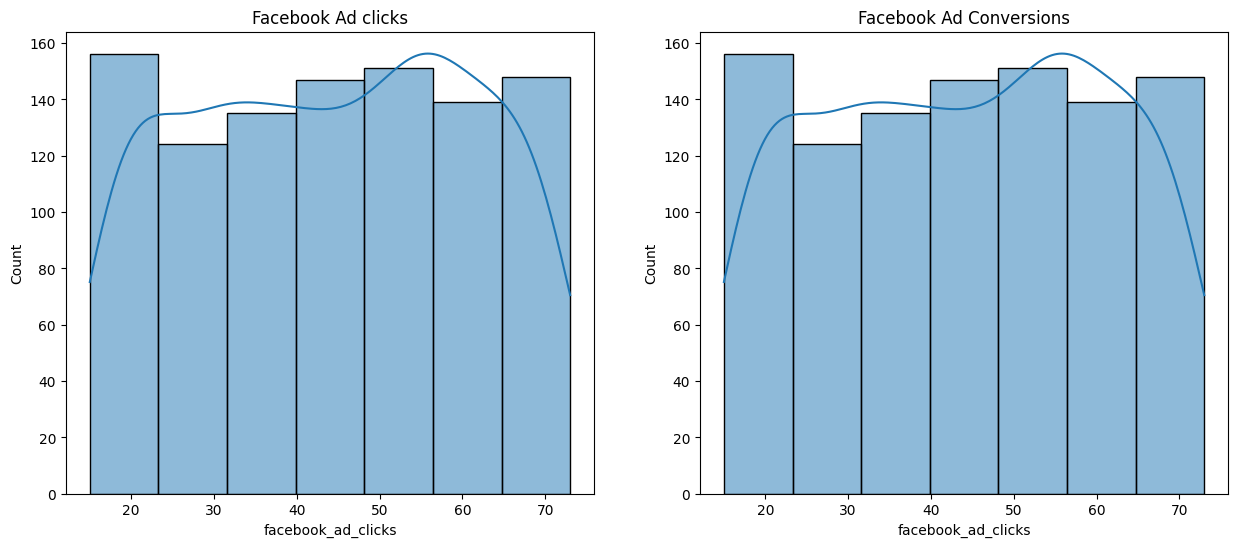

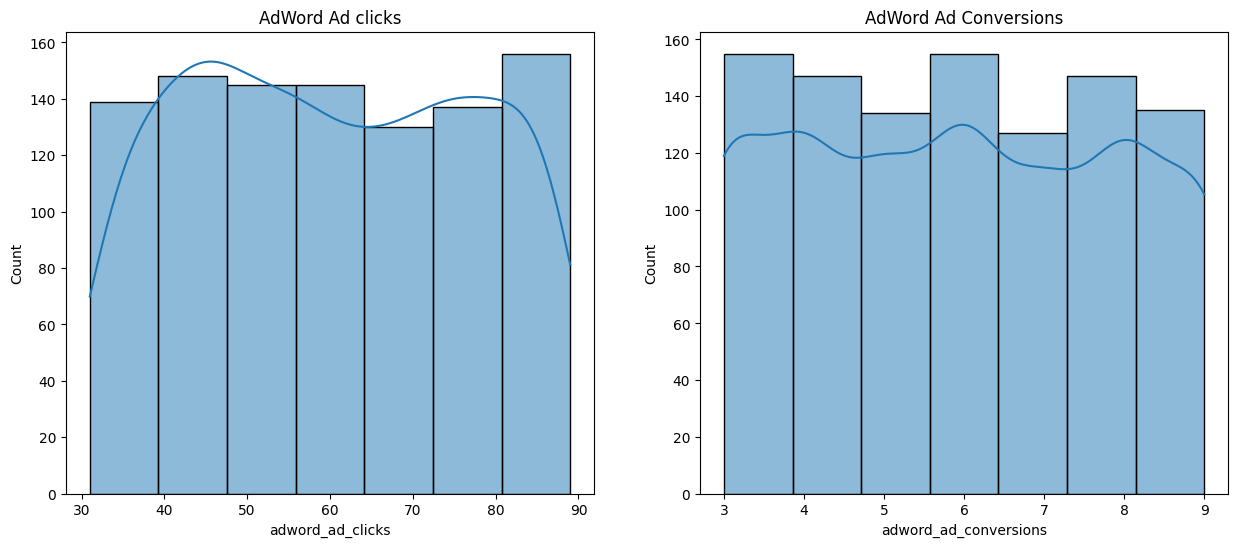

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Facebook Ad clicks')
sns.histplot(df['facebook_ad_clicks'],bins = 7, edgecolor = 'k',kde = True)
plt.subplot(1,2,2)
plt.title('Facebook Ad Conversions')
sns.histplot(df['facebook_ad_clicks'], bins = 7, edgecolor = 'k', kde = True)
plt.show()

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('AdWord Ad clicks')
sns.histplot(df['adword_ad_clicks'],bins = 7, edgecolor = 'k',kde = True)
plt.subplot(1,2,2)
plt.title('AdWord Ad Conversions')
sns.histplot(df['adword_ad_conversions'], bins = 7, edgecolor = 'k', kde = True)
plt.show()

In [11]:
def create_conversion_category(conversion_col):
    category = []
    for conversion in df[conversion_col]:
        if conversion < 6:
            category.append('less than 6')
        elif 6 <= conversion < 11:
            category.append('6-10')
        elif 11 <= conversion < 16:
            category.append('10-15')
        else:
            category.append('more than 15')
    return category

df['facebook_conversion_category'] = create_conversion_category('facebook_ad_conversions')
df['adwords_conversion_category'] = create_conversion_category('adword_ad_conversions')


In [12]:
df[['facebook_ad_conversions','facebook_conversion_category','adword_ad_conversions','adwords_conversion_category']].head()

,facebook_ad_conversions,facebook_conversion_category,adword_ad_conversions,adwords_conversion_category
0,14,10-15,9,6-10
1,9,6-10,6,6-10
2,15,10-15,9,6-10
3,9,6-10,3,less than 6
4,12,10-15,4,less than 6


In [13]:
df['facebook_conversion_category'].value_counts()

facebook_conversion_category
10-15           341
6-10            337
more than 15    257
less than 6      65
Name: count, dtype: int64

In [14]:
facebook = pd.DataFrame(df['facebook_conversion_category'].value_counts()).reset_index().rename(columns = {'facebook_conversion_category':'category'})

In [15]:
facebook

,category,count
0,10-15,341
1,6-10,337
2,more than 15,257
3,less than 6,65


In [16]:
df['adwords_conversion_category'].value_counts()

adwords_conversion_category
6-10           564
less than 6    436
Name: count, dtype: int64

In [17]:
adwords = pd.DataFrame(df['adwords_conversion_category'].value_counts()).reset_index().rename(columns = {'adwords_conversion_category':'category'})
adwords

,category,count
0,6-10,564
1,less than 6,436


In [18]:
category_df = pd.merge(facebook,adwords,on = 'category',how = 'outer').fillna(0)
category_df


,category,count_x,count_y
0,10-15,341,0.0
1,6-10,337,564.0
2,less than 6,65,436.0
3,more than 15,257,0.0


In [19]:
category_df = category_df.iloc[[3,1,0,2]]
category_df

,category,count_x,count_y
3,more than 15,257,0.0
1,6-10,337,564.0
0,10-15,341,0.0
2,less than 6,65,436.0


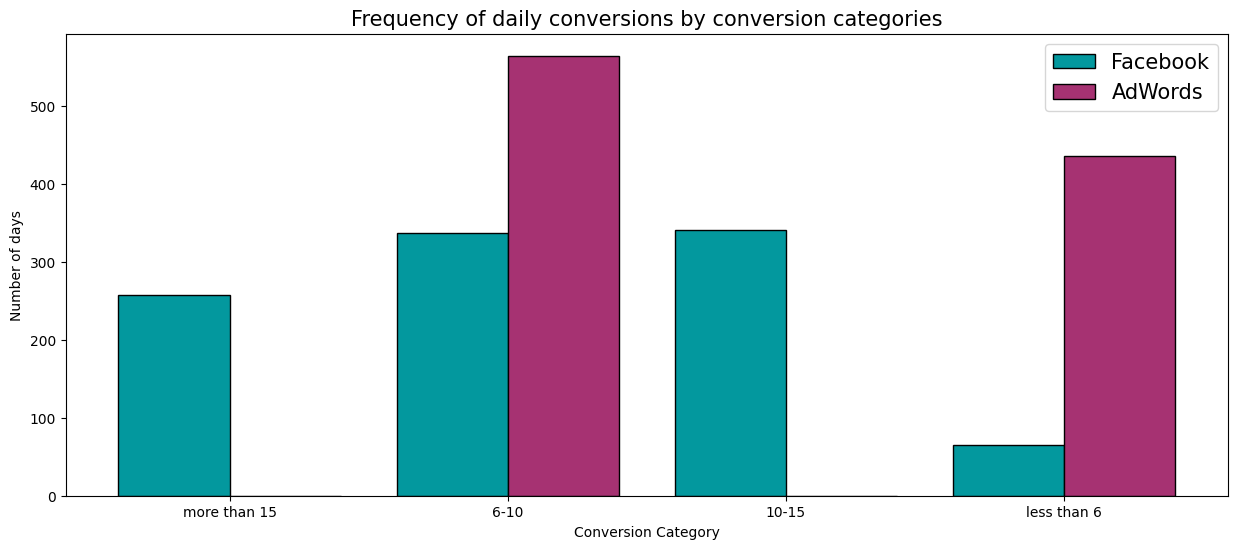

In [20]:
X_axis = np.arange(len(category_df))
plt.figure(figsize=(15,6))
plt.bar(X_axis - 0.2, category_df['count_x'],0.4, label = 'Facebook', color = '#03989E',linewidth = 1, edgecolor = 'k')
plt.bar(X_axis + 0.2, category_df['count_y'],0.4, label = 'AdWords', color = '#A63272',linewidth = 1, edgecolor = 'k')

plt.xticks(X_axis,category_df['category'])
plt.xlabel('Conversion Category')
plt.ylabel('Number of days')
plt.title('Frequency of daily conversions by conversion categories', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()


Do more clicks on the ad really lead to more sales

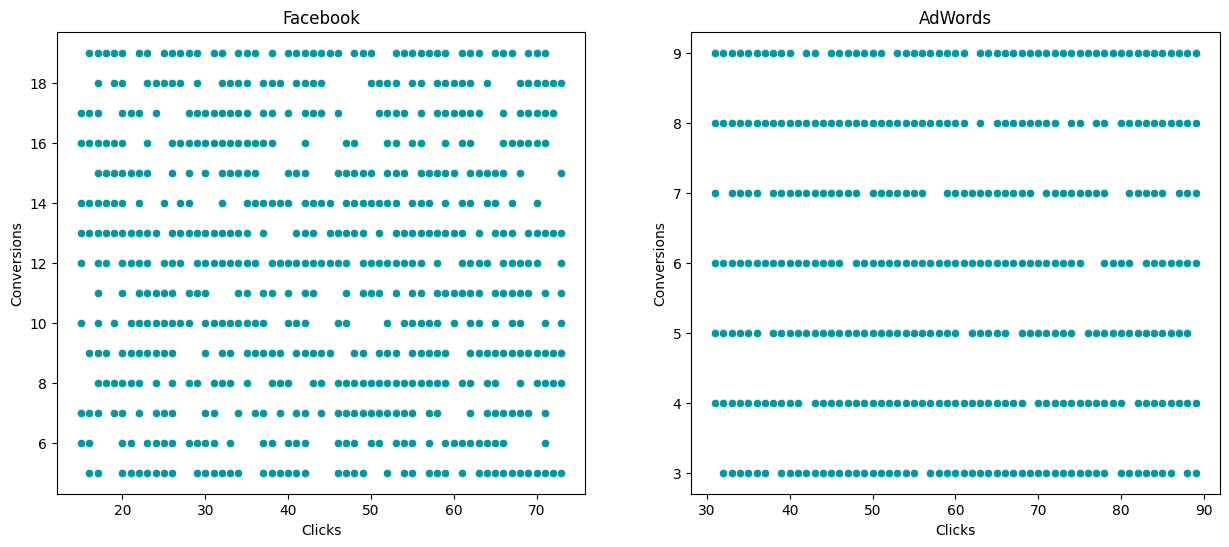

In [21]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Facebook')
sns.scatterplot(x = df['facebook_ad_clicks'],y = df['facebook_ad_conversions'], color = '#03989E')
plt.xlabel('Clicks')
plt.ylabel('Conversions')

plt.subplot(1,2,2)
plt.title('AdWords')
sns.scatterplot(x = df['adword_ad_clicks'],y = df['adword_ad_conversions'], color = '#03989E')
plt.xlabel('Clicks')
plt.ylabel('Conversions')

plt.show()

In [22]:
facebook_corr = df[['facebook_ad_conversions','facebook_ad_clicks']].corr()
facebook_corr

,facebook_ad_conversions,facebook_ad_clicks
facebook_ad_conversions,1.000000,-0.005009
facebook_ad_clicks,-0.005009,1.000000


In [23]:
adwords_corr = df[['adword_ad_conversions','adword_ad_clicks']].corr()
adwords_corr

,adword_ad_conversions,adword_ad_clicks
adword_ad_conversions,1.000000,0.004162
adword_ad_clicks,0.004162,1.000000


In [24]:
print('Correlation Coeff \n---------')
print('Facebook :', round(facebook_corr.values[0, 1], 2))
print('AdWords  :', round(adwords_corr.values[0, 1], 2))

Correlation Coeff 
---------
Facebook : -0.01
AdWords  : 0.0


In [25]:
print('Mean Conversion \n----------')
print('Facebook: ', round(df['facebook_ad_conversions'].mean(),2))
print('Adwords: ', round(df['adword_ad_conversions'].mean(),2))

t_stats, p_value = st.ttest_ind(a = df['facebook_ad_conversions'],b = df['adword_ad_conversions'], equal_var= False)
print('\nT statistic', t_stats,'\np-value',p_value)

# comparing the p value with signigficance of 5% or 0.05

if p_value < 0.05:
    print('\np-value is less than significance value, reject the null hypothesis')
else:
    print('\np-value is greater than significance value, accept the null hypothesis')
    

Mean Conversion 
----------
Facebook:  11.98
Adwords:  5.93

T statistic 40.25906231407935 
p-value 6.886351887267426e-237

p-value is less than significance value, reject the null hypothesis


In [26]:
X = df[['facebook_ad_clicks']]
y = df[['facebook_ad_conversions']]

reg_model = LinearRegression()
reg_model.fit(X,y)
prediction = reg_model.predict(X)

r2 = r2_score(y,prediction) * 100
mse = mean_squared_error(y,prediction)
print('Accuracy (R2 score):', round(r2,2), '%')
print('Mean Squared Error:', round(mse,2))

Accuracy (R2 score): 0.0 %
Mean Squared Error: 18.46


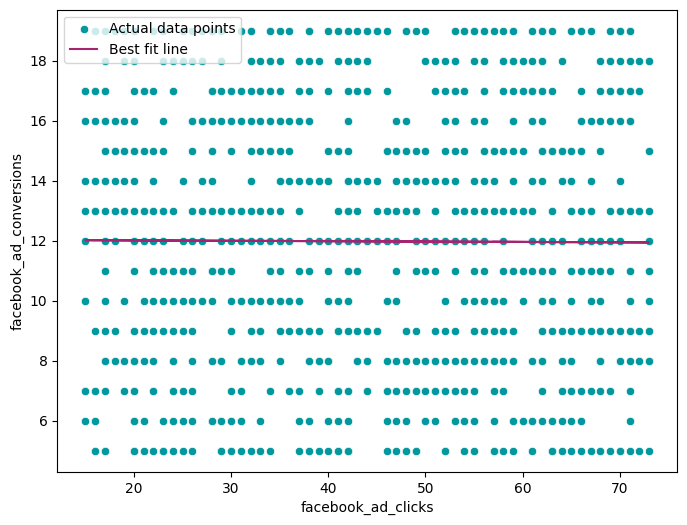

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = df['facebook_ad_clicks'], y = df['facebook_ad_conversions'], color = '#03989E',label = 'Actual data points')
plt.plot(df['facebook_ad_clicks'], prediction, color = '#A62372', label = 'Best fit line')
plt.legend()
plt.show()

In [28]:
print(f'For {50} Clicks Expected Conversion : {round(reg_model.predict([[50]])[0][0],2)}')
print(f'For {80} Clicks Expected Conversion : {round(reg_model.predict([[80]])[0][0],2)}')

For 50 Clicks Expected Conversion : 11.97
For 80 Clicks Expected Conversion : 11.93


In [29]:
df = df[['date_of_campaign','facebook_ad_views','facebook_ad_clicks','facebook_ad_conversions','facebook_cost_per_ad','facebook_ctr','facebook_conversion_rate','facebook_cost_per_click']]
df.head()

,date_of_campaign,facebook_ad_views,facebook_ad_clicks,facebook_ad_conversions,facebook_cost_per_ad,facebook_ctr,facebook_conversion_rate,facebook_cost_per_click
0,2021-12-22,3172,62,14,141,1.95,22.58,2.27
1,2021-12-24,3211,38,9,186,1.18,23.68,4.89
2,2021-12-25,1936,53,15,66,2.74,28.30,1.25
3,2021-12-25,1194,45,9,71,3.77,20.00,1.58
4,2021-12-26,2479,44,12,174,1.77,27.27,3.95


In [30]:
df['month'] = df['date_of_campaign'].dt.month
df['week'] = df['date_of_campaign'].dt.weekday